In [1]:
# 'Cell 1: Imports and Configuration'
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import backend.processing_logic as processing_logic
import json
from datetime import datetime

# --- Configuration ---
YOLO_MODEL_PATH = 'backend/resource/yolov8n-seg.pt'
OLLAMA_API_URL = 'http://localhost:11434/api/generate'
DEEPSEEK_MODEL_NAME = 'deepseek-r1:8b'
TEST_IMAGE_PATH = 'backend/resource/bus.jpg'  
METADATA_PATH = 'backend/resource/capture_metadata.json'

print("Configuration set successfully.")
print(f"YOLO Model Path: {YOLO_MODEL_PATH}")
print(f"Ollama API URL: {OLLAMA_API_URL}")
print(f"DeepSeek Model: {DEEPSEEK_MODEL_NAME}")
print(f"Metadata Path: {METADATA_PATH}")

Configuration set successfully.
YOLO Model Path: backend/resource/yolov8n-seg.pt
Ollama API URL: http://localhost:11434/api/generate
DeepSeek Model: deepseek-r1:8b
Metadata Path: backend/resource/capture_metadata.json


In [2]:
# 'Cell 2: Load YOLO Model'
print("Loading YOLO model...")
try:
    yolo_model = YOLO(YOLO_MODEL_PATH)
    print(f"YOLO model '{YOLO_MODEL_PATH}' loaded successfully.")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    yolo_model = None

Loading YOLO model...
YOLO model 'backend/resource/yolov8n-seg.pt' loaded successfully.


Image 'backend/resource/bus.jpg' loaded successfully.


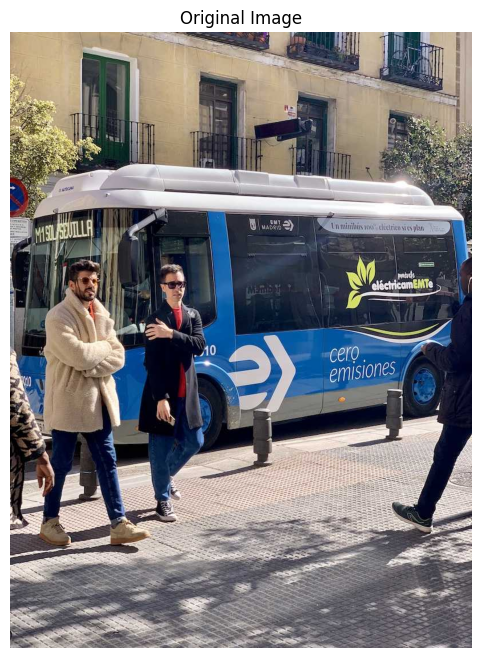

In [3]:
# 'Cell 3: Capture or Load Image'

# choose mode for image input
# mode = input("Select mode ('camera' for webcam, 'image' for file): ").strip().lower()
mode = 'image'  # for testing purposes, you can change to 'image' to load a file
image_bgr = None
capture_time = None

if mode == 'camera':
    # Initialize webcam
    cap = cv2.VideoCapture(0)  # default camera index is 0
    if not cap.isOpened():
        print('Error: Unable to access the webcam.')
    else:
        try:
            # capture a single frame
            ret, frame = cap.read()
            if ret:
                image_bgr = frame
                capture_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                print(f'Image captured from webcam at {capture_time}.')
                # save the captured image
                os.makedirs('backend/resource', exist_ok=True)
                cv2.imwrite('backend/resource/captured_image.jpg', image_bgr)
                # save metadata
                metadata = {"capture_time": capture_time}
                with open(METADATA_PATH, 'w') as f:
                    json.dump(metadata, f)
                print(f'Metadata saved to {METADATA_PATH}.')
            else:
                print('Error: Failed to capture image from webcam.')
        finally:
            cap.release()  # release the webcam resource
elif mode == 'image':
    # check if the test image exists
    if not os.path.exists(TEST_IMAGE_PATH):
        print(f'Error: Test image not found at \'{TEST_IMAGE_PATH}\'')
        print('Please place a test image in the project root directory.')
    else:
        # read the image from file (RGB format)
        image_bgr = cv2.imread(TEST_IMAGE_PATH)
        print(f'Image \'{TEST_IMAGE_PATH}\' loaded successfully.')
else:
    print('Error: Invalid mode selected. Please choose "camera" or "image".')

# show the loaded image if available
if image_bgr is not None:
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
else:
    print('No image loaded.')

In [4]:
# 'Cell 4: Process Image and Describe'

print('Starting the image segmentation pipeline...')
print('This may take a moment as it involves YOLO segmentation.')

# check if the model and image are loaded successfully
if 'yolo_model' in locals() and yolo_model is not None and 'image_bgr' in locals() and image_bgr is not None:
    # Call the processing logic to segment and describe the image
    json_detections, annotated_image_bgr = processing_logic.process_image_and_describe(
        image_bgr,
        yolo_model,
        DEEPSEEK_MODEL_NAME,
        OLLAMA_API_URL,
        capture_time=capture_time
    )
    print('Segmentation complete.')
    print('JSON Detections:', json_detections)
else:
    print('Skipping segmentation due to errors in previous steps (model or image not loaded).')
    json_detections = json.dumps({"message": "Segmentation failed."})
    annotated_image_bgr = image_bgr  # show the original image if segmentation fails

Starting the image segmentation pipeline...
This may take a moment as it involves YOLO segmentation.

0: 640x480 4 persons, 1 bus, 1 skateboard, 150.6ms
Speed: 7.7ms preprocess, 150.6ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 480)
Segmentation complete.
JSON Detections: {"image_height": 1080, "image_width": 810, "detections": [{"class": "person", "confidence": 0.8777948021888733, "bbox": [670, 388, 809, 877], "dominant_color": [229.36287809348906, 162.3065994500462, 54.68276810265704], "color_name": "blue", "mask_area": 0.024942844078646546}, {"class": "person", "confidence": 0.8602193593978882, "bbox": [48, 396, 242, 904], "dominant_color": [88.56842064819708, 103.00280483352495, 131.36987301404122], "color_name": "green", "mask_area": 0.05950274348422496}, {"class": "person", "confidence": 0.8412283658981323, "bbox": [222, 407, 344, 861], "dominant_color": [208.96698773830224, 165.80801440535083, 74.79240860891012], "color_name": "blue", "mask_area": 0.03999428440

No capture time available (image mode).


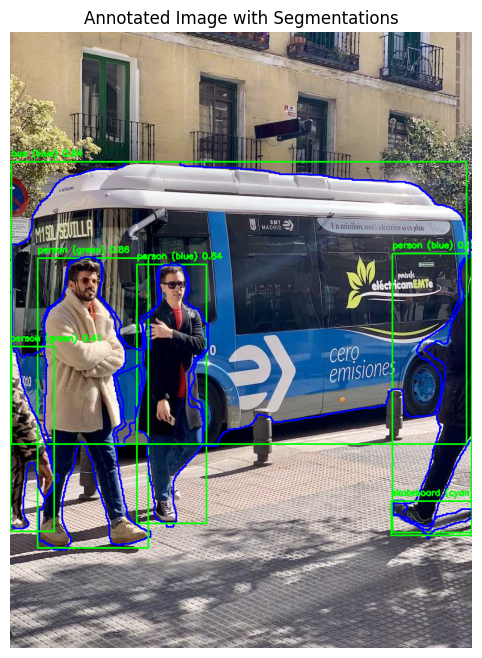

In [5]:
# Cell 5: Display Annotated Image

# show capture time if available
if capture_time:
    print(f"Image captured at: {capture_time}")
else:
    print("No capture time available (image mode).")

# show annotated image 
if annotated_image_bgr is not None:
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_image_rgb)
    plt.title('Annotated Image with Segmentations')
    plt.axis('off')
    plt.show()
else:
    print('No annotated image available.')

In [13]:
# Cell 6: Answer Questions
import sys

# Loop to ask questions about the image
while True:
    question = input("Enter your question about the image (or 'quit' to exit): ").strip()
    if question.lower() == 'quit':
        break
    if not question:
        print("Please enter a valid question.")
        sys.stdout.flush()
        continue
    
    print(f"Question: {question}")
    print("Generating answer, please wait...")
    sys.stdout.flush()
    
    print(f"Question: {question}")
    final_answer, complete_response, metrics = processing_logic.answer_question_with_deepseek(
        json_detections,
        question,
        OLLAMA_API_URL,
        DEEPSEEK_MODEL_NAME
    )
    print(f"Answer: {final_answer}")
    sys.stdout.flush()
    print("-------------------------------------------------------------------------------------------------------------------------")


Question: what did you see
Generating answer, please wait...
Question: what did you see
Answer: I saw three people and one bus in the scene.
-------------------------------------------------------------------------------------------------------------------------
Question: what colors these objects are
Generating answer, please wait...
Question: what colors these objects are
Answer: Based on the detection data:

*   **Person (1):** Dominant color is dark brown/black (#35201F).
*   **Person (2):** Dominant color is neutral grey/beige (#6D6C69).
*   **Person (3):** Dominant color is dark brown (#403138, similar to first person but slightly different shade).
*   **Bus:** Dominant color is deep red/burgundy (#746458).
*   **Skateboard:** Dominant color is neutral grey (#AAAAAA).
-------------------------------------------------------------------------------------------------------------------------
